## Imports and Constant Definitions

In [34]:
import netCDF4 as nc
import pandas as pd
from datetime import datetime
from scipy.constants import Boltzmann
from scipy import log
import numpy as np

In [186]:
month_dict = {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June",
    7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"}

seasons_for_days = {
    'Winter': list(range(305, 366)) + list(range(1, 32)),
    'Spring': list(range(32, 121)),
    'Summer': list(range(121, 213)),
    'Autumn': list(range(213, 305))
}

## Load Data
### You can run this segment only once and save the csv file. From next time you can just load the previously saved csv file.

In [2]:
def get_dataframe_from_nc_file(nc_file_path):
    ds = nc.Dataset(nc_file_path)
    longitude = ds['longitude'][:]
    latitude = ds['latitude'][:]
    level = ds['level'][:]
    time = ds['time']
    time_convert = nc.num2date(time[:], time.units, time.calendar)[:]
    t = ds['t'][:]
    
    rows = []
    for time_i, a in enumerate(t):
        for level_i, b in enumerate(a):
            for lat_i, c in enumerate(b):
                for lon_i, d in enumerate(c):
                    rows.append({
                        'Latitude': latitude[lat_i],
                        'Longitude': longitude[lon_i],
                        'Time': time_convert[time_i],
                        'PressureLevel': level[level_i],
                        'Temperature': d
                    })
    df = pd.DataFrame(rows)
    df.to_csv(f'{nc_file_path[:-3]}.csv')
    return df
    

In [3]:
def get_average_temperature_of_a_day(df):
    df['date_only'] = df.apply(lambda x: datetime.strptime(str(x['Time']),'%Y-%m-%d %H:%M:%S').date(), axis=1)
    df = df.groupby(['date_only', 'PressureLevel'], as_index=False)['Temperature'].mean()
    return df

In [78]:
def convert_pressure_to_altitude(p_level, temp):
    P0 = 101325
    P = p_level * 100
    H = 7
    return H * log(P0/P)
    

In [79]:
def get_season_for_month(month):
    if month in [1, 11, 12]:
        return 'Winter'
    elif month in [2, 3, 4]:
        return 'Spring'
    elif month in [5, 6, 7]:
        return 'Summer'
    elif month in [8, 9, 10]:
        return 'Autumn'
    else:
        raise ValueError

In [80]:
dfs = []
nc_file_list = ['2021_jan2apr.nc', '2021_sep2dec.nc']

for file in nc_file_list:
    df = get_dataframe_from_nc_file(file)
    df = get_average_temperature_of_a_day(df)
    dfs.append(df)

In [81]:
final_df = pd.concat(dfs).reset_index(drop=True)

In [82]:
final_df['Day'] = final_df.apply(lambda x: x['date_only'].timetuple().tm_yday, axis=1)
final_df['Month'] = final_df.apply(lambda x: x['date_only'].month, axis=1)
final_df['Height'] = final_df.apply(lambda x: convert_pressure_to_altitude(x['PressureLevel'], x['Temperature']), axis=1)
final_df['Season'] = final_df.apply(lambda x: get_season_for_month(x['Month']), axis=1)

/home/lenovo/miniconda3/envs/manisha/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  """


In [83]:
final_df.to_csv('netcdf_data.csv', index=False)

# Visualization

In [84]:
final_df = pd.read_csv('netcdf_data.csv')

In [85]:
final_df

,date_only,PressureLevel,Temperature,Day,Month,Height,Season
0,2021-01-01,1,253.939596,1,1,48.446428,Winter
1,2021-01-01,2,248.117071,1,1,43.594398,Winter
2,2021-01-01,3,240.647872,1,1,40.756142,Winter
3,2021-01-01,5,231.591278,1,1,37.180362,Winter
4,2021-01-01,7,228.517443,1,1,34.825057,Winter
...,...,...,...,...,...,...,...
8949,2021-12-31,900,284.619778,365,12,0.829665,Winter
8950,2021-12-31,925,286.311245,365,12,0.637872,Winter
8951,2021-12-31,950,287.664449,365,12,0.451194,Winter
8952,2021-12-31,975,289.215775,365,12,0.269366,Winter


In [169]:
# create a dataframe which contains temperature values for all 365 days,
# columns represent temperature for each heights and rows contain temperatures for each day

all_df = pd.DataFrame()
all_df['Day'] = final_df['Day'].unique()

group = final_df.groupby(['Height'])
for height, df in group:
    all_df[height] = df['Temperature'].values
all_df

,Day,0.09214090568396603,0.2693655615739949,0.45119396639682,0.6378716959719493,0.8296645152887496,1.026860654055624,1.229773412168391,1.4387441542161592,1.6541457648834346,...,18.70696116421341,21.062266820561906,24.638046186923837,27.476301943680987,32.32833220760061,34.82505681517173,37.180362471520226,40.756141837882154,43.59439759463931,48.446427858558934
0,1,293.941040,292.600191,291.090226,289.564292,288.083383,286.656380,285.654618,284.804835,284.121518,...,196.307071,205.846708,212.339930,218.105433,225.547369,228.517443,231.591278,240.647872,248.117071,253.939596
1,2,294.756860,293.383839,291.904488,290.351446,288.860255,287.422346,286.460156,285.911135,285.298471,...,194.646453,204.264688,211.525823,218.206466,226.687009,226.309206,229.355932,240.204557,250.678107,261.219349
2,3,295.832780,294.439116,292.956338,291.403919,289.892552,288.489151,287.686028,287.459581,287.026237,...,193.218436,203.174279,211.610420,219.489516,227.424542,223.674635,226.118279,240.471123,249.370831,259.672383
3,4,298.253678,296.854016,295.368044,293.765459,292.267023,290.999709,290.350200,289.386686,287.632435,...,192.810176,202.163170,212.814169,222.338694,224.344787,222.724442,225.778724,240.512798,253.469874,259.882005
4,5,297.784735,296.377439,294.900581,293.319418,291.940087,290.506540,289.034434,287.192860,285.340146,...,192.271359,201.448383,213.236763,223.947199,223.624781,223.794442,227.900340,240.777649,257.596805,261.215688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,361,291.529818,290.175569,288.742669,287.282233,285.770307,284.032947,282.409162,280.587851,278.893100,...,207.618572,212.282999,218.152503,220.044034,225.477668,231.688422,239.137833,250.669690,254.803178,249.733850
238,362,291.579143,290.206612,288.759086,287.279621,285.780306,284.145179,282.571167,280.998723,279.414637,...,206.419389,212.388590,217.280838,219.136550,225.652658,230.958017,239.918011,250.043160,251.863948,246.144808
239,363,289.433747,288.065395,286.572648,285.182804,283.610733,282.087240,280.581359,278.956977,277.397965,...,206.019637,210.141558,216.522450,218.026839,224.410343,231.252477,241.480381,249.710941,250.430824,246.386062
240,364,290.012967,288.627153,287.050306,285.727175,284.065183,282.334017,281.156773,279.764616,278.323059,...,206.964432,210.403483,215.435350,217.668278,223.853137,231.368142,241.108090,250.294936,250.414854,247.416151


In [90]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

### Line Plot (Month-wise)

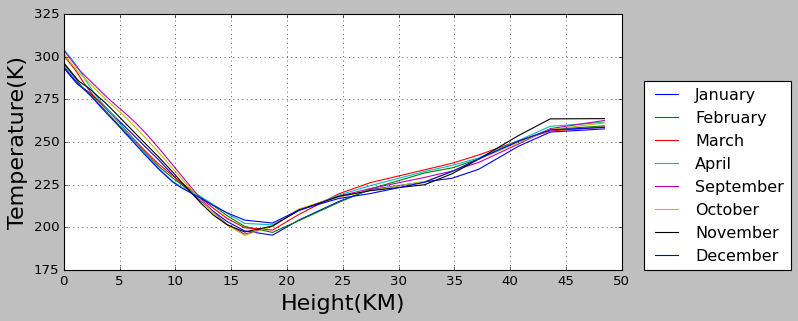

In [93]:
fig,ax = plt.subplots(1, figsize=(9,4))

month_df = final_df.groupby(['Month','Height'], as_index=False)['Temperature'].mean()
group_month = month_df.groupby(['Month'])

for month, df in group_month:
    heights = df["Height"].values
    avg_temp = df["Temperature"].values
    ax.plot(heights, avg_temp, label=month_dict[month])
    
ax.set_xlabel("Height(KM)", fontsize=20)
ax.set_ylabel("Temperature(K)", fontsize=20)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.grid()
plt.legend(loc=(1.04,0))
plt.savefig('./output/month_wise_line_plot_netcdf.pdf')
plt.show()

### Line Plot (Season-wise)

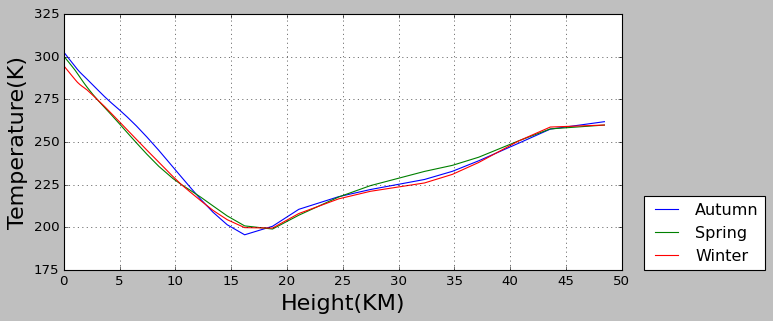

In [95]:
fig,ax = plt.subplots(1, figsize=(9,4))

season_df = final_df.groupby(['Season','Height'], as_index=False)['Temperature'].mean()
group = season_df.groupby(['Season'])

for season, df in group:
    heights = df["Height"].values
    avg_temp = df["Temperature"].values
    ax.plot(heights, avg_temp, label=season)
    
ax.set_xlabel("Height(KM)", fontsize=20)
ax.set_ylabel("Temperature(K)", fontsize=20)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.grid()
plt.legend(loc=(1.04,0))
plt.savefig('./output/month_wise_line_plot_netcdf.pdf')
plt.show()

### Contour Plot

In [172]:
new_indices = list(range(31, len(all_df))) + list(range(0, 31))
contour_df = all_df.drop(['Day'], 1)
contour_df = contour_df.reindex(new_indices)
contour_df

,0.092141,0.269366,0.451194,0.637872,0.829665,1.026861,1.229773,1.438744,1.654146,1.876387,...,18.706961,21.062267,24.638046,27.476302,32.328332,34.825057,37.180362,40.756142,43.594398,48.446428
31,289.961024,288.617838,287.178449,285.730257,284.236650,282.650580,281.049086,279.595675,278.298682,277.208429,...,197.629848,206.565390,214.167794,219.583616,226.410628,232.430078,238.774204,248.167237,255.945768,260.088667
32,291.846688,290.503892,289.021035,287.542775,286.048857,284.487558,282.907797,281.408738,280.043118,278.843652,...,198.963375,205.478486,213.042799,219.736061,226.460639,231.521404,236.752998,245.238136,251.765166,257.147648
33,293.930368,292.587571,291.065065,289.576055,288.075594,286.475735,284.912956,283.192435,281.561729,279.878754,...,199.154925,205.531301,211.830558,219.511561,227.037937,232.249512,237.302954,243.543010,250.606129,258.723046
34,294.813492,293.486352,291.962834,290.447494,288.931453,287.324662,285.798105,284.283700,282.764388,280.982951,...,200.732427,206.401649,212.442443,219.136328,227.532508,231.305160,235.768140,244.005565,250.451503,256.875552
35,293.242455,291.873018,290.441574,288.869135,287.329881,285.791718,284.177293,282.534279,280.720436,278.731402,...,201.370407,204.981267,211.895758,220.792195,229.416380,231.151235,235.926818,247.636911,256.016109,259.691623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,290.854820,289.468167,288.037813,286.573497,285.080124,283.728136,282.573695,282.193633,281.746658,281.127061,...,201.220610,205.778080,216.578877,222.977141,225.826709,234.493270,238.597922,246.109887,253.271391,258.924255
27,292.090040,290.768042,289.302245,287.767665,286.270164,284.809586,283.366068,282.381834,281.391367,280.450054,...,201.677946,207.784252,216.642675,222.232987,228.448193,236.137219,240.797825,247.752745,253.875564,259.947828
28,291.471534,290.081220,288.666913,287.130074,285.642778,284.120349,282.551494,281.087567,279.458030,277.683993,...,204.045017,207.726374,216.520531,221.198430,228.533101,232.784745,238.694281,251.395464,258.497066,260.181521
29,289.836466,288.475052,287.034572,285.541511,284.054370,282.525009,280.859873,279.455615,278.022847,276.607294,...,203.344485,207.532876,215.652442,220.602826,228.683131,231.012032,236.692783,251.289991,260.252407,260.381406


/home/lenovo/miniconda3/envs/manisha/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(0, -5.0, ''),
 Text(0, 0.0, ''),
 Text(0, 5.0, ''),
 Text(0, 10.0, ''),
 Text(0, 15.0, ''),
 Text(0, 20.0, ''),
 Text(0, 25.0, ''),
 Text(0, 30.0, ''),
 Text(0, 35.0, ''),
 Text(0, 40.0, '')]

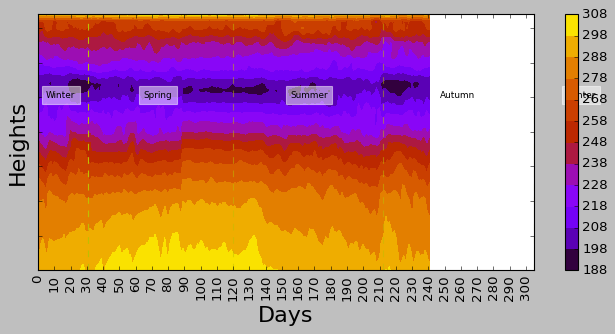

In [98]:
# get values for heights
heights = final_df['Height'].values

# get the dataframe values as numpy matrix
all_data = contour_df.to_numpy()
contour_data = all_data.T # transpose the data to plot days in x-axis of contour plot

contour_data= np.vstack((contour_data,contour_data[0])) # done from example code from rejina.ipynb, why????

plt.style.use('classic') # style from rejina.ipynb
fig,ax = plt.subplots(1, figsize=(10,4))
gap = 10
c_levels = np.arange(188,309,gap) # set levels of temperature at which to draw contours and label colorbar
cs = ax.contourf(contour_data, levels=c_levels, cmap='gnuplot') # style from rejina.ipynb
cbar = fig.colorbar(cs)
cbar.set_ticks(c_levels) # set labels in the colorbar

# Uncomment this section if you want fine lines for contour levels
# cnt = ax.contour(contour_data, levels=levels, colors='k') # colors from rejina.ipynb, to draw contour lines
# for c in cnt.collections:
#     c.set_linewidth(0.5) # change this value to change width of contour lines


# uncomment following to set dashed lines like grid, change the ranges as per need
# ax.hlines(range(0,241, 50),0,365,linestyle='--')
# ax.vlines(range(0,365, 25),0,241,linestyle='--')

# These are the new codes added on June 14, 2020
a1=0.5
h = 25
ax.axvline(x=31, color='y', linestyle='--', alpha=1)
ax.axvline(x=120, color='y', linestyle='--', alpha=0.5)
ax.axvline(x=212, color='y', linestyle='--', alpha=0.5)
ax.axvline(x=305, color='y', linestyle='--', alpha=0.5)

# Comment following if you don't want the text.
t1 = ax.text(5, h, 'Winter', fontsize=8)
t2 = ax.text(65, h, 'Spring', fontsize=8)
t3 = ax.text(155, h, 'Summer', fontsize=8)
t4 = ax.text(247, h, 'Autumn', fontsize=8)
t5 = ax.text(325, h, 'Winter', fontsize=8)
t1.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white')) # set white transparent background for text
t2.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white'))
t3.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white'))
t4.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white'))
t5.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white'))

ax.set_xlabel("Days", fontsize=20)
ax.set_ylabel("Heights", fontsize=20)

ax.xaxis.set_major_locator(MultipleLocator(10)) # put ticks in x-axis for every 10 points
ax.set_xticklabels(ax.get_xticks().astype(int), rotation = 90) # set labels in x-axis

# todo: write understandable code segment for following
ax.yaxis.set_major_locator(MultipleLocator(5)) # put ticks in y-axis for every 20 points
ax.set_yticklabels(np.arange(heights[0]-10, heights[-1]+1, 10)) # set labels in y-axis


# Pauses

## Estimation of Pauses

In [99]:
from scipy.signal import argrelextrema

In [100]:
def filter_consecutive(data, stepsize=1):
    '''
    filter consecutive indices according to stepsize
    eg 1: if array of indices for minimas is [2,3,4, 9,10, 15] and stepsize is 1, it will return [2, 4, 9, 15]
    eg 2: if array of indices for minimas is [2,3,4, 9,10, 15] and stepsize is 2, it will return [2, 9, 15]
    '''
    consec = np.split(data, np.where(np.diff(data) != stepsize)[0]+1)
    return [x[0] for x in consec]

In [101]:
def filter_extremas(x, max_index):
    '''
    filter unique points of extremas and ignore the endpoints of an array
    ex: in an array [0, 1, 2, 2, 2, 1, 0], maxima can be at indices 2, 3, 4 at values 2, 2, 2
    this function returns only a single index for such case (in former example returns the index 2)
    '''
    x = np.array(filter_consecutive(x)) # filter consecutive indices whose differences is 1
    x = np.array(filter_consecutive(x, stepsize=2)) # filter consecutive indices whose differences is 2
    if x[0] == 0: # if left end is an extrema, ignore it
        x = x[1:]
    if x[-1] == max_index: # if right end is an extrema, ignore it
        x = x[:-1]
    return x

In [149]:
def extract_maxima(x, y):
    '''
    get unique maxima for Stratopause at a height between 20KM and 50KM
    the height was chosen according to position of maximas seen in above line plots
    '''
    indices = argrelextrema(x, np.greater_equal)[0] # returns all maximas obtained in an array sequence
    indices = filter_extremas(indices, 240) # filter duplicate consecutive maximas and maximas at endpoints
    final_indices = [] # initialize indices for stratopause
    for i in indices:
        if 35 < y[i] < 50:
            final_indices.append(i)
    return {
        'stratos_temp': x[final_indices],
        'stratos_height': y[final_indices]
    }
def extract_minima(x, y):
    '''
    get unique minimas for Tropopause and Mesopause
    at a height between 0KM and 20KM (for Tropopause) and between 55KM and 120KM (for Mesopause)
    the height was chosen according to position of minimas seen in above line plots
    '''
    indices = argrelextrema(x, np.less_equal)[0] # returns all minimas obtained in an array sequence
    indices = filter_extremas(indices, 240) # filter duplicate consecutive minimas and minimas at endpoints
    t_indices = [] # initialize indices for tropopause
    s_indices = [] # initialize indices for mesopause
    for i in indices:
        if 12 < y[i] <= 25:
            t_indices.append(i)
        if 55 <= y[i] <=120:
            s_indices.append(i)
    return {
        'tropos_temp': x[t_indices],
        'tropos_height': y[t_indices],
        'mesos_temp': x[s_indices],
        'mesos_height': y[s_indices]
    }

In [155]:
def get_extrema_item(extrema):
    if len(extrema) != 0:
        return extrema.item()
    else:
        return -100 # default value

In [188]:
def get_season_for_day(day):
    seasons = seasons_for_days.keys()
    for season in seasons:
        if day in seasons_for_days[season]:
            return season

In [189]:
all_df__ = all_df.set_index('Day')
all_df_transposed = all_df__.T
days = all_df_transposed.columns

rows = []
for day in days:
    temperatures = all_df_transposed[day].values
    minimas = extract_minima(temperatures, heights) # get unique minimas for Tropopause and Mesopause
    maximas = extract_maxima(temperatures, heights) # get unique maxima for Stratopause

    rows.append({
        'Day': day,
        'Tropopause_temp': get_extrema_item(minimas['tropos_temp']),
        'Stratopause_temp': get_extrema_item(maximas['stratos_temp']),
        'Mesopause_temp': get_extrema_item(minimas['mesos_temp']),
        'Tropopause_height': get_extrema_item(minimas['tropos_height']),
        'Stratopause_height': get_extrema_item(maximas['stratos_height']),
        'Mesopause_height': get_extrema_item(minimas['mesos_height']),

    })

pauses_df = pd.DataFrame(rows)
pauses_df['Season'] = pauses_df.apply(lambda x: get_season_for_day(x['Day']), axis=1)

In [190]:
pauses_df.describe()

,Day,Tropopause_temp,Stratopause_temp,Mesopause_temp,Tropopause_height,Stratopause_height,Mesopause_height
count,242.000000,242.000000,242.000000,242.0,242.000000,242.000000,242.0
mean,183.508264,197.712106,260.881926,-100.0,17.441827,47.343694,-100.0
std,127.161519,3.661796,3.177323,0.0,1.261308,2.037555,0.0
min,1.000000,188.434986,250.036593,-100.0,14.648232,43.594398,-100.0
25%,61.250000,195.020453,259.131404,-100.0,16.210237,48.446428,-100.0
50%,244.500000,197.513876,261.219059,-100.0,16.210237,48.446428,-100.0
75%,304.750000,200.285160,262.936672,-100.0,18.706961,48.446428,-100.0
max,365.000000,206.964432,269.314262,-100.0,18.706961,48.446428,-100.0


## Line Plot of the Pauses

In [197]:
def line_plot_pause(pause):
    fig,ax = plt.subplots(1, 2, figsize=(14, 4))

    ax[0].plot(pauses_df['Day'].values, pauses_df[f'{pause}_temp'].values, label=pause)
    ax[0].set_xlabel('Days', fontsize = 16)
    ax[0].set_ylabel('Temperature', fontsize = 16)
    ax[0].grid()

    ax[1].plot(pauses_df['Day'].values, pauses_df[f'{pause}_height'].values, label=pause)
    ax[1].set_xlabel('Days', fontsize = 16)
    ax[1].set_ylabel('Height', fontsize = 16)
    ax[1].grid()


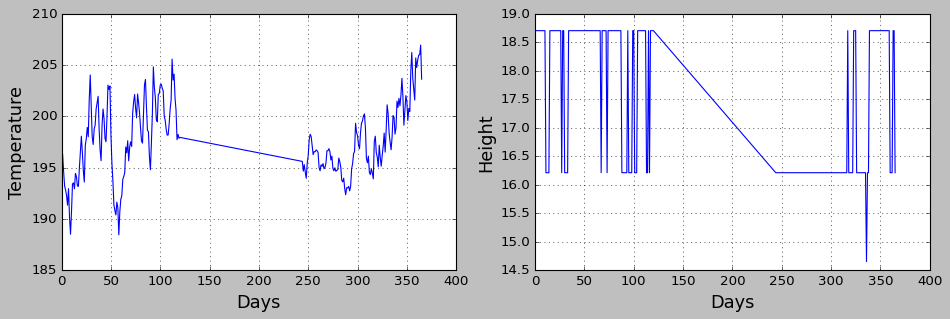

In [198]:
line_plot_pause('Tropopause')

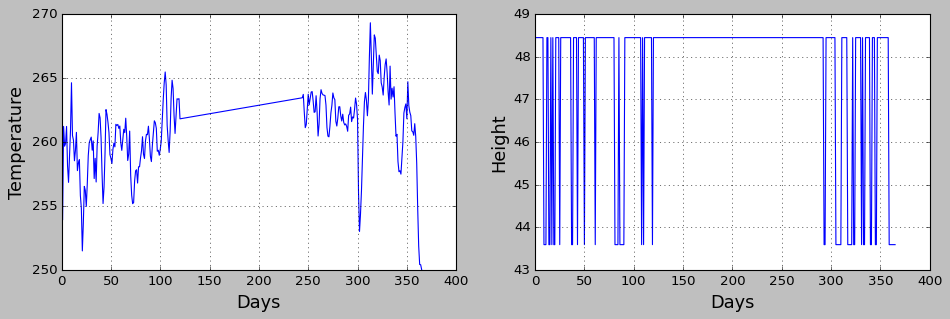

In [199]:
line_plot_pause('Stratopause')

# Vertical Profiles

In [185]:
# heights of tropopause, stratopause and mesopause estimated
topo_height = pauses_df['Tropopause_height'].mean()
strato_height = pauses_df['Stratopause_height'].mean()

## Vertical Profile (Season-wise) with Estimated Pauses

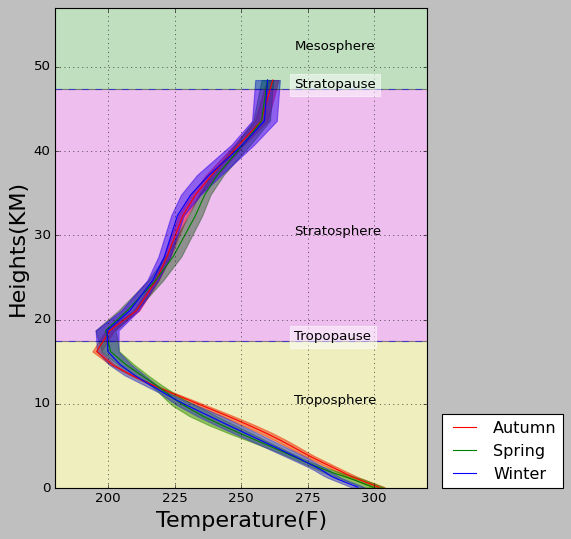

In [234]:
a1=0.5
text_loc_h = 270
colors = ['r', 'g', 'b', 'y']

fig,ax = plt.subplots(1, figsize=(6,7.5))

season_df = final_df.groupby(['Season','Height'], as_index=False).agg({'Temperature': ['mean', 'std']})
group = season_df.groupby(['Season'])

i = 0
for season, df in group:
    x =  df['Temperature', 'mean'].values
    y = df['Height'].values
    x_error = df['Temperature', 'std'].values
    
    ax.plot(x, y, label=season, color=colors[i]) # central line plot for each season
    ax.fill_betweenx(y, x-x_error, x+x_error, alpha=a1, edgecolor='dimgray', color=colors[i]) # plot std deviation as area with gray edge
    ax.set_xlabel('Height', fontsize=16)
    ax.set_ylabel('Temperature (K)', fontsize=16)
    i = i + 1

# give background colors to different layers of the atmosphere
plt.axhspan(0, topo_height, facecolor='y', alpha=0.25) # Troposphere region background color
plt.axhspan(topo_height, strato_height, facecolor='m', alpha=0.25)
plt.axhspan(strato_height, meso_height, facecolor='g', alpha=0.25)

# plot horizontal boundary lines at pauses
plt.axhline(y=topo_height, color='b', linestyle='--', alpha=0.5) # border for Troposphere and Stratosphere
plt.axhline(y=strato_height, color='b', linestyle='--', alpha=0.5)

plt.text(text_loc_h, 10, 'Troposphere')
plt.text(text_loc_h, 30, 'Stratosphere')
plt.text(text_loc_h, 52, 'Mesosphere')

t1 = plt.text(text_loc_h, topo_height + 0.1, 'Tropopause')
t2 = plt.text(text_loc_h, strato_height + 0.1, 'Stratopause')
t1.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white')) # set white transparent background for text
t2.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white'))


ax.set_ylim(0,57)
    
ax.set_xlabel("Temperature(F)", fontsize=20)
ax.set_ylabel("Heights(KM)", fontsize=20)
ax.xaxis.set_major_locator(MultipleLocator(25)) # put ticks in x-axis for every 25 K
ax.yaxis.set_major_locator(MultipleLocator(10)) # put ticks in y-axis for every 10 KM
ax.grid()
plt.legend(loc=(1.04,0))
plt.savefig('./output/month_wise_line_plot_vertical.pdf')
plt.show()

In [228]:
def vertical_profile_seasonal(season, a1=0.5, a2=0.25):
    '''
    plot vertical temperature profile for a season and save it.
    '''
    a1=0.5
    text_loc_h = 270

    fig,ax = plt.subplots(1, figsize=(5,7.5))

    season_df = final_df.groupby(['Season','Height'], as_index=False).agg({'Temperature': ['mean', 'std']})
    group = season_df.groupby(['Season'])

    for s, _df in group:
        if s == season:
            df = _df
            break
    x =  df['Temperature', 'mean'].values
    y = df['Height'].values
    x_error = df['Temperature', 'std'].values

    ax.plot(x, y, label=season) # central line plot for each season
    ax.fill_betweenx(y, x-x_error, x+x_error, alpha=a1, edgecolor='dimgray') # plot std deviation as area with gray edge
    ax.set_xlabel('Height', fontsize=16)
    ax.set_ylabel('Temperature (K)', fontsize=16)

    # give background colors to different layers of the atmosphere
    plt.axhspan(0, topo_height, facecolor='y', alpha=0.25) # Troposphere region background color
    plt.axhspan(topo_height, strato_height, facecolor='m', alpha=0.25)
    plt.axhspan(strato_height, meso_height, facecolor='g', alpha=0.25)

    # plot horizontal boundary lines at pauses
    plt.axhline(y=topo_height, color='b', linestyle='--', alpha=0.5) # border for Troposphere and Stratosphere
    plt.axhline(y=strato_height, color='b', linestyle='--', alpha=0.5)

    plt.text(text_loc_h, 10, 'Troposphere')
    plt.text(text_loc_h, 30, 'Stratosphere')
    plt.text(text_loc_h, 52, 'Mesosphere')

    t1 = plt.text(text_loc_h, topo_height + 0.1, 'Tropopause')
    t2 = plt.text(text_loc_h, strato_height + 0.1, 'Stratopause')
    t1.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white')) # set white transparent background for text
    t2.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white'))


    ax.set_ylim(0,57)

    ax.set_xlabel("Temperature(F)", fontsize=20)
    ax.set_ylabel("Heights(KM)", fontsize=20)
    ax.xaxis.set_major_locator(MultipleLocator(25)) # put ticks in x-axis for every 25 K
    ax.yaxis.set_major_locator(MultipleLocator(10)) # put ticks in y-axis for every 10 KM
    ax.grid()
    plt.legend(loc=(1.04,0))
    plt.savefig('./output/month_wise_line_plot_vertical.pdf')
    plt.show()

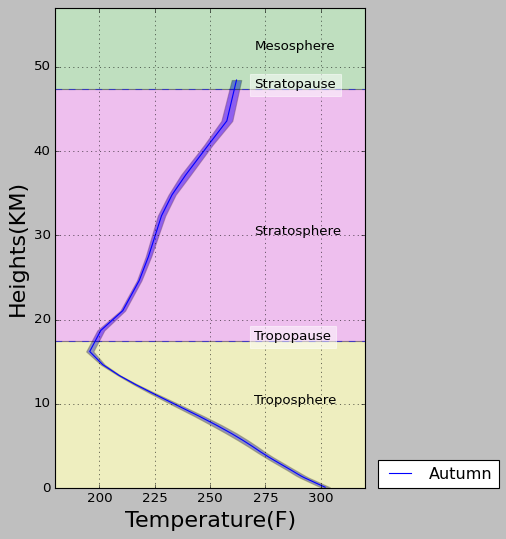

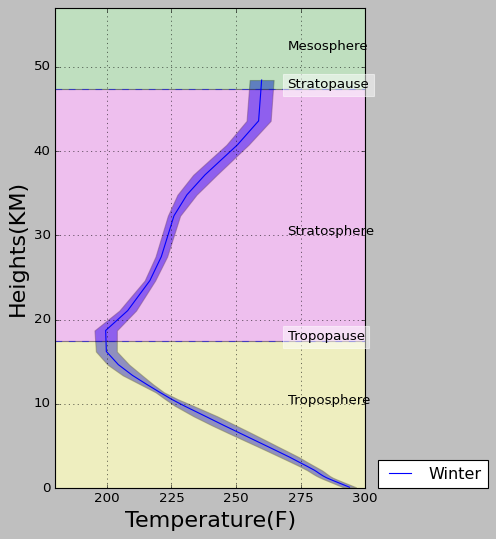

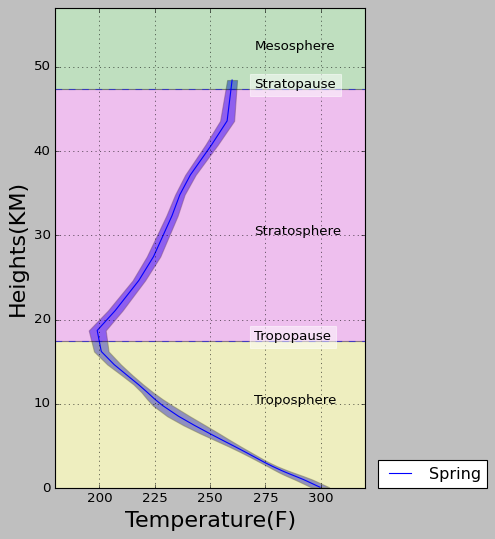

In [232]:
# seasons = seasons_for_days.keys()
seasons = ['Autumn', 'Winter', 'Spring']
for season in seasons:
    vertical_profile_seasonal(season)